<a href="https://colab.research.google.com/github/juan-medinaf/Datathon3-CHL5230-Group12/blob/main/CHL5230_Datathon_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [441]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

In [442]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
from sklearn.discriminant_analysis import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

warnings.filterwarnings('ignore')

In [444]:
from sklearn.preprocessing import MinMaxScaler

In [445]:
from sklearn.ensemble import RandomForestClassifier

In [446]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV

In [447]:
pip install -U imbalanced-learn

In [448]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [449]:
pip install category_encoders

In [450]:
from category_encoders import OneHotEncoder, TargetEncoder

In [453]:
from google.colab import files
imported= files.upload()

Saving pulse.csv to pulse.csv


In [454]:
data= pd.read_csv(io.BytesIO(imported['pulse.csv']))

### **Classification of Long Covid Outcomes**

**Exploration and initial recoding of Features of Interest**

Select subset of data for those that had covid

In [455]:
data_covid= data[data['HADCOVIDRV']=='1']

In [456]:
len(data_covid)

40782

Recode Values in Features and recode Outcome of interest

Note that the dataset has categories for values where they saw the question but did not respond and where they did not see the question. As such, I will be treating the values missing when they saw the question but did not respond as missing not at random and those with no notation as missing at random.

In [457]:
len(data_covid[data_covid['LONGCOVID']=='M'])

2222

Since the output variable has missing values, to avoid distorting the results,particularly since it is unbalanced (and imputation can further this umbalance), I have decided to select only a subset that does not have missing (at random) and perform imputations only on those missing at random on predictor columns.

In [460]:
data_covid = data_covid[data_covid['LONGCOVID']!='M']

In [461]:
set(data_covid['LONGCOVID'])

{'-99', '1', '2'}

In [462]:
len(data_covid[data_covid['LONGCOVID']=='-99'])

55

In [463]:
set(data_covid['RRACE'])

{1, 2, 3, 4}

In [464]:
data_covid['is_white']= pd.NA
data_covid.loc[data_covid['RRACE'].isin([1]), 'is_white'] = 1
data_covid.loc[data_covid['RRACE'].isin([2,3,4]), 'is_white'] = 0

In [465]:
len(data_covid[data_covid['is_white']==1])

32230

In [466]:
len(data_covid[data_covid['is_white']==0])

6330

In [467]:
set(data_covid['SEXUAL_ORIENTATION'])

{-99, 1, 2, 3, 4, 5}

In [468]:
data_covid['is_straight']=np.nan
data_covid.loc[data_covid['SEXUAL_ORIENTATION'].isin([1,3,4,5]), 'is_straight'] = 'no'
data_covid.loc[data_covid['SEXUAL_ORIENTATION'].isin([2]), 'is_straight'] = 'yes'
data_covid.loc[data_covid['SEXUAL_ORIENTATION'].isin([-99]), 'is_straight'] = 'chose not to respond'

In [469]:
len(data_covid[data_covid['is_straight']=='chose not to respond'])

350

In [470]:
set(data_covid['ANYWORK'])

{'-99', '1', '2', 'M'}

In [471]:
data_covid['is_employed']=np.nan
data_covid.loc[data_covid['ANYWORK'].isin(['1']), 'is_employed'] = 'yes'
data_covid.loc[data_covid['ANYWORK'].isin(['2']), 'is_employed'] = 'no'
data_covid.loc[data_covid['ANYWORK'].isin(['-99']), 'is_employed'] = 'chose not to respond'

In [472]:
len(data_covid[data_covid['is_employed']=='chose not to respond'])

170

In [473]:
set(data_covid['RECVDVACC'])

{'-99', '1', '2'}

In [474]:
data_covid['is_vaccinated']=np.nan
data_covid.loc[data_covid['RECVDVACC'].isin(['1']), 'is_vaccinated'] = 'yes'
data_covid.loc[data_covid['RECVDVACC'].isin(['2']), 'is_vaccinated'] = 'no'
data_covid.loc[data_covid['RECVDVACC'].isin(['-99']), 'is_vaccinated'] = 'chose not to respond'

In [475]:
len(data_covid[data_covid['is_vaccinated']=='chose not to respond'])

58

In [476]:
set(data_covid['SYMPTOMS'])

{'-99', '1', '2', '3', '4'}

In [477]:
len(data_covid[data_covid['SYMPTOMS']=='-99'])

85

In [478]:
data_covid['cov_highly_symptomatic']=np.nan
data_covid.loc[data_covid['SYMPTOMS'].isin(['3','4']), 'cov_highly_symptomatic'] = 'yes'
data_covid.loc[data_covid['SYMPTOMS'].isin(['1','2']), 'cov_highly_symptomatic'] = 'no'
data_covid.loc[data_covid['SYMPTOMS'].isin(['-99']), 'cov_highly_symptomatic'] = 'chose not to respond'

In [479]:
len(data_covid[data_covid['cov_highly_symptomatic']=='chose not to respond'])

85

In [480]:
set(data_covid['REGION'])

{1, 2, 3, 4}

In [481]:
data_covid['region']=np.nan
data_covid.loc[data_covid['REGION'].isin([1]), 'region'] = 'Northeast'
data_covid.loc[data_covid['REGION'].isin([2]), 'region'] = 'South'
data_covid.loc[data_covid['REGION'].isin([3]), 'region'] = 'Midwest'
data_covid.loc[data_covid['REGION'].isin([4]), 'region'] = 'West'

In [482]:
set(data_covid['GENID_DESCRIBE'])

{-99, 1, 2, 3, 4}

In [483]:
data_covid['is_female']=np.nan
data_covid.loc[data_covid['GENID_DESCRIBE'].isin([2]), 'is_female'] = 'yes'
data_covid.loc[data_covid['GENID_DESCRIBE'].isin([1, 3, 4]), 'is_female'] = 'no'
data_covid.loc[data_covid['GENID_DESCRIBE'].isin([-99]), 'is_female'] = 'chose not to respond'

In [484]:
len(data_covid[data_covid['is_female']=='chose not to respond'])

537

Notice that the 'chose not to respond' category is relatively too small. As such, since they are missing not at random they are difficult to impute and are not too telling in the analysis because of their size, so I decided to drop them (and to impute the values missig at random). In this way, moreover, I can turn many of the categorical variables to binary.



In [485]:
data_covid = data_covid[data_covid['is_vaccinated']!='chose not to respond']
data_covid = data_covid[data_covid['is_employed']!='chose not to respond']
data_covid = data_covid[data_covid['is_straight']!='chose not to respond']
data_covid = data_covid[data_covid['LONGCOVID']!='-99']
data_covid= data_covid = data_covid[data_covid['cov_highly_symptomatic']!='chose not to respond']
data_covid= data_covid = data_covid[data_covid['is_female']!='chose not to respond']

turn target variable to binary

In [486]:
data_covid.loc[data_covid['LONGCOVID'].isin(['1']), 'LONGCOVID'] = 1
data_covid.loc[data_covid['LONGCOVID'].isin(['2']), 'LONGCOVID'] = 0

Explore Numeric Features of Interest: Birth Year and Total Number of People in the Household. Create age variable from birth year variable.

In [487]:
data_covid['TBIRTH_YEAR'].isna().sum()

0

In [488]:
data_covid['TBIRTH_YEAR'].describe()

count    37455.000000
mean      1973.156214
std         15.459472
min       1935.000000
25%       1961.000000
50%       1974.000000
75%       1986.000000
max       2005.000000
Name: TBIRTH_YEAR, dtype: float64

In [489]:
data_covid['age']= 2023-data_covid['TBIRTH_YEAR']

In [490]:
data_covid['THHLD_NUMPER'].isna().sum()

0

In [491]:
data_covid['THHLD_NUMPER'].describe()

count    37455.000000
mean         2.813136
std          1.469553
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         10.000000
Name: THHLD_NUMPER, dtype: float64

Define function for scores/metrics of models

In [493]:
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

# **Model Building and Analysis**

Select Relevant features and Output Variable.

In [494]:
data_covid= data_covid[['THHLD_NUMPER','age','is_employed','is_vaccinated','is_straight','is_white', 'cov_highly_symptomatic','region','is_female','LONGCOVID']]

<Axes: >

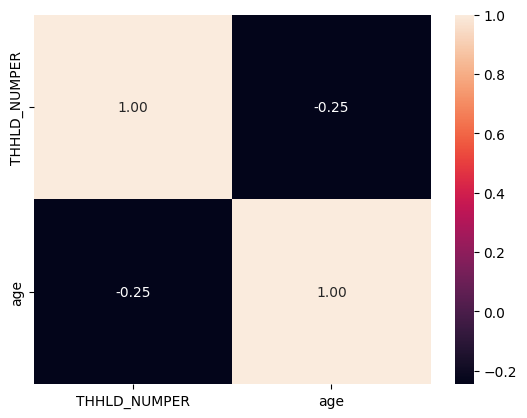

In [495]:
#Check for colinearity
corr_matrix1= data_covid.corr()
sns.heatmap(corr_matrix1, annot=True, fmt=".2f")

In [496]:
#Check if there are any notable, unreasonable outliers. None were found.
data_covid.describe()

,THHLD_NUMPER,age
count,37455.000000,37455.000000
mean,2.813136,49.843786
std,1.469553,15.459472
min,1.000000,18.000000
25%,2.000000,37.000000
50%,2.000000,49.000000
75%,4.000000,62.000000
max,10.000000,88.000000


In [498]:
#check missing values
data_covid.isna().sum()

THHLD_NUMPER                0
age                         0
is_employed               478
is_vaccinated               0
is_straight                 0
is_white                    0
cov_highly_symptomatic      0
region                      0
is_female                   0
LONGCOVID                   0
dtype: int64

In [499]:
#check balance of dataset based on outcome variable
print(len(data_covid[data_covid['LONGCOVID']==1]))
print(len(data_covid[data_covid['LONGCOVID']==0]))

9411
28044


Split the dataset into training and test sets (note that the data allocated for test will be subdivided into validation and test sets before major transformations in the data, as shown in the 'feature engineering and preprocessing on the test and validation sets')

In [500]:
train = data_covid.sample(frac=0.6, random_state=20)  # 60% for training
test = data_covid.drop(train.index)  # Remaining data for testing

**Feature engineering and preprocessing on the training set**

Impute missing values with mode (missing values only on is_employed column)

In [501]:
train.mode()

,THHLD_NUMPER,age,is_employed,is_vaccinated,is_straight,is_white,cov_highly_symptomatic,region,is_female,LONGCOVID
0,2,41,yes,yes,yes,1,yes,South,yes,0


In [357]:
mode_employed_train= 'yes'

In [502]:
train.isnull().sum()

THHLD_NUMPER                0
age                         0
is_employed               290
is_vaccinated               0
is_straight                 0
is_white                    0
cov_highly_symptomatic      0
region                      0
is_female                   0
LONGCOVID                   0
dtype: int64

In [503]:
train['is_employed']= train['is_employed'].fillna(mode_employed_train)

In [504]:
set(train['is_employed'])

{'no', 'yes'}

Now that no missing, recode as dummy variables, where applicable

In [505]:
train.loc[train['is_employed'].isin(['yes']), 'is_employed'] = 1
train.loc[train['is_employed'].isin(['no']), 'is_employed'] = 0

In [506]:
train.loc[train['is_vaccinated'].isin(['yes']), 'is_vaccinated'] = 1
train.loc[train['is_vaccinated'].isin(['no']), 'is_vaccinated'] = 0

In [507]:
train.loc[train['is_straight'].isin(['yes']), 'is_straight'] = 1
train.loc[train['is_straight'].isin(['no']), 'is_straight'] = 0

In [508]:
train.loc[train['cov_highly_symptomatic'].isin(['yes']), 'cov_highly_symptomatic'] = 1
train.loc[train['cov_highly_symptomatic'].isin(['no']), 'cov_highly_symptomatic'] = 0

In [509]:
train.loc[train['LONGCOVID'].isin(['1']), 'LONGCOVID'] = 1
train.loc[train['LONGCOVID'].isin(['2']), 'LONGCOVID'] = 0

In [510]:
train.loc[train['is_female'].isin(['yes']), 'is_female'] = 1
train.loc[train['is_female'].isin(['no']), 'is_female'] = 0

Encode values in region into numeric

In [511]:
encoder= TargetEncoder()
train['region']= encoder.fit_transform(train['region'],train['LONGCOVID'])

In [512]:
train

,THHLD_NUMPER,age,is_employed,is_vaccinated,is_straight,is_white,cov_highly_symptomatic,region,is_female,LONGCOVID
59964,4,36,1,1,1,1,0,0.244930,1,0
13450,5,36,0,1,1,1,1,0.244930,1,0
53789,2,28,1,1,0,1,1,0.244930,1,0
12220,3,53,0,1,1,1,0,0.267067,1,0
33384,5,40,1,0,1,1,1,0.244930,0,0
...,...,...,...,...,...,...,...,...,...,...
45026,2,54,0,1,1,0,1,0.256879,1,1
50292,2,53,1,1,1,1,1,0.244930,0,1
40832,3,64,1,1,1,1,0,0.244930,0,0
32978,6,49,0,1,1,0,1,0.256879,0,0


Scale columns with values greater than 1 with MinMaxScaler (scales to the range of 0 to 1).

In [513]:
scaler= MinMaxScaler()

In [517]:
X_train= train.drop('LONGCOVID', axis=1)

In [518]:
X_train[['THHLD_NUMPER','age']]= scaler.fit_transform(X_train[['THHLD_NUMPER','age']])

In [519]:
Y_train= train['LONGCOVID'].astype('int')

Since there is a significant class inbalance (25-75), which will significantly hinder the classification task, I will use undersampling of the majority class ('LONGCOVID' =0) on the training set.

In [520]:
len(train[train['LONGCOVID']==1])/len(train)

0.2509233302184844

In [521]:
len(train[train['LONGCOVID']==0])/len(train)

0.7490766697815155

In [522]:
under_sampler = RandomUnderSampler(sampling_strategy=0.8, random_state=20)
X_train_resampled, Y_train_resampled = under_sampler.fit_resample(X_train, Y_train)

Note: had to increase sampling strategy because the random under_sampler did not fix the inbalance at 0.5. The new class balance is as follows:

In [523]:
print(len(Y_train_resampled[Y_train_resampled==1])/len(Y_train_resampled))
print(len(Y_train_resampled[Y_train_resampled==0])/len(Y_train_resampled))

0.4444707180578545
0.5555292819421455


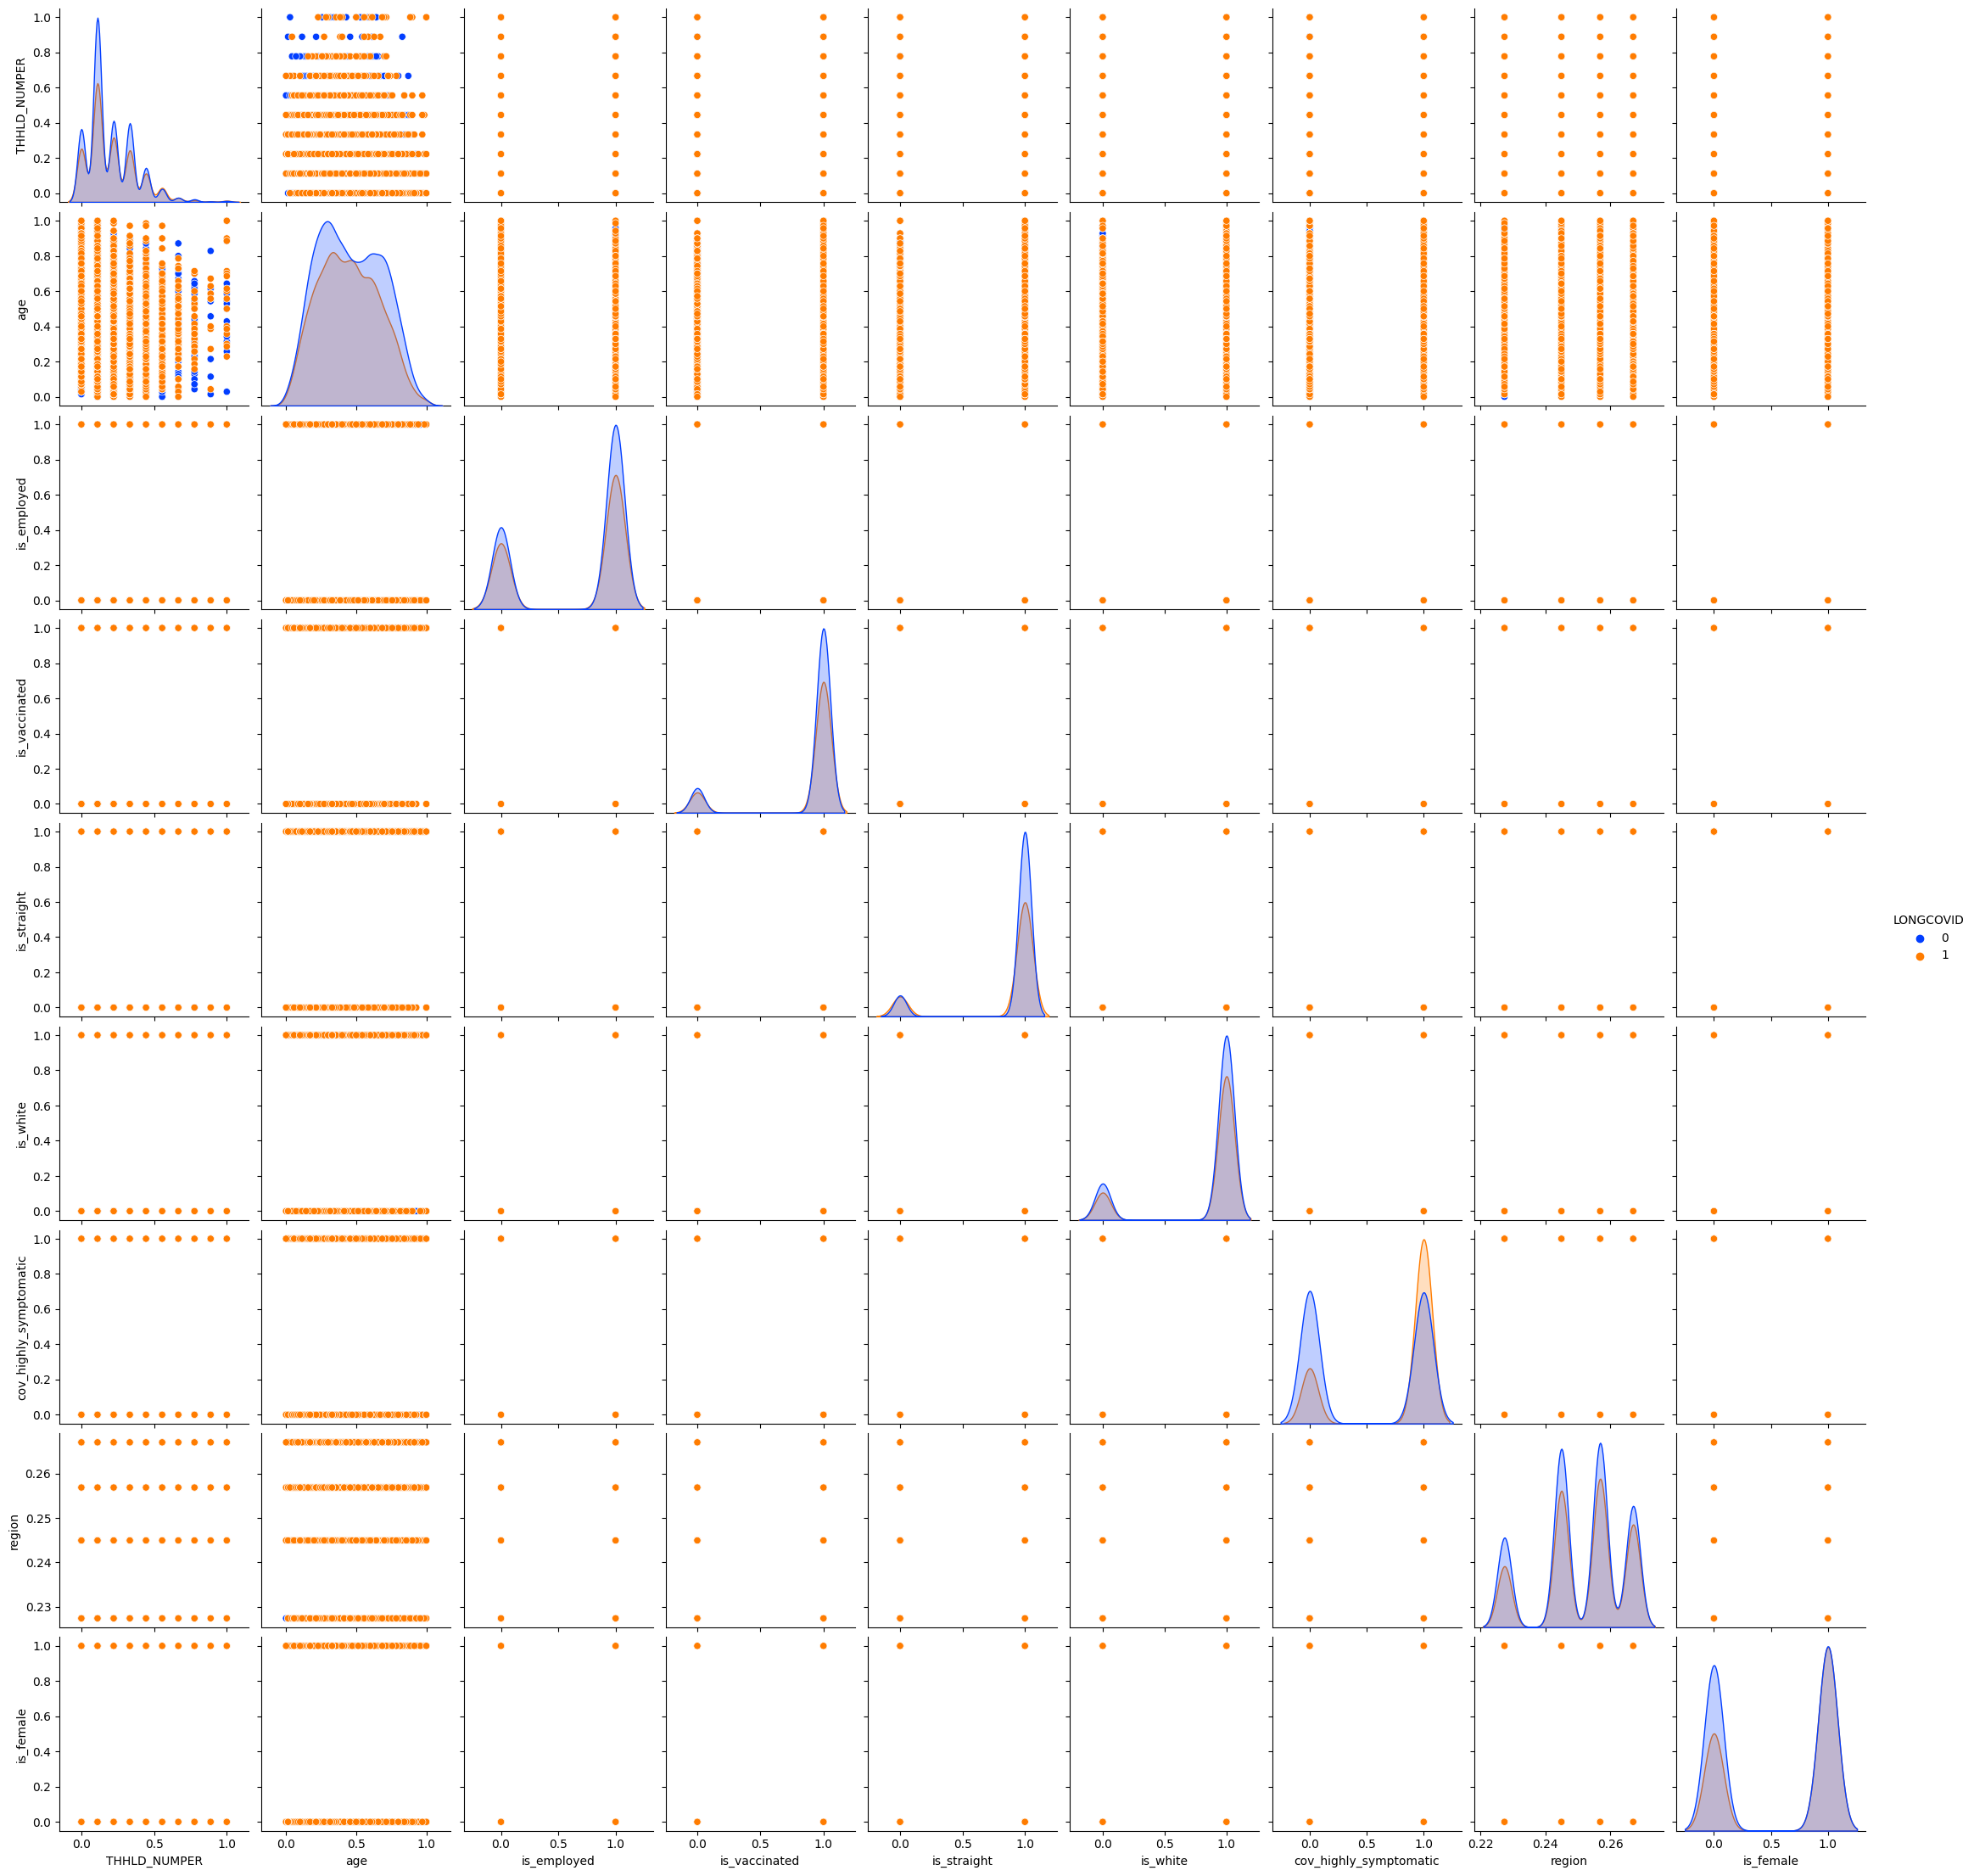

In [525]:
#Exploratory Visualization after undersampling. Notice that among those with long covid, more are females.
train_res= X_train_resampled
train_res['LONGCOVID']= Y_train_resampled
sns.pairplot(train_res, hue='LONGCOVID', palette="bright")
plt.show()
X_train_resampled= X_train_resampled.drop('LONGCOVID',axis=1)

**Feature engineering and preprocessing on the test and validation sets**

In [526]:
test.isnull().sum()

THHLD_NUMPER                0
age                         0
is_employed               188
is_vaccinated               0
is_straight                 0
is_white                    0
cov_highly_symptomatic      0
region                      0
is_female                   0
LONGCOVID                   0
dtype: int64

Impute missing of is_employed with mode value of the trainning set.

In [527]:
test['is_employed']= test['is_employed'].fillna(mode_employed_train)

In [528]:
set(test['is_employed'])

{'no', 'yes'}

Now that no missing, recode categorical variables as dumy variables, where applicable

In [529]:
test.loc[test['is_employed'].isin(['yes']), 'is_employed'] = 1
test.loc[test['is_employed'].isin(['no']), 'is_employed'] = 0

In [530]:
test.loc[test['is_vaccinated'].isin(['yes']), 'is_vaccinated'] = 1
test.loc[test['is_vaccinated'].isin(['no']), 'is_vaccinated'] = 0

In [531]:
test.loc[test['is_straight'].isin(['yes']), 'is_straight'] = 1
test.loc[test['is_straight'].isin(['no']), 'is_straight'] = 0

In [532]:
test.loc[test['cov_highly_symptomatic'].isin(['yes']), 'cov_highly_symptomatic'] = 1
test.loc[test['cov_highly_symptomatic'].isin(['no']), 'cov_highly_symptomatic'] = 0

In [533]:
test.loc[test['LONGCOVID'].isin(['1']), 'LONGCOVID'] = 1
test.loc[test['LONGCOVID'].isin(['2']), 'LONGCOVID'] = 0

In [534]:
test.loc[test['is_female'].isin(['yes']), 'is_female'] = 1
test.loc[test['is_female'].isin(['no']), 'is_female'] = 0

split into validation and testing sets

In [535]:
validation = test.sample(frac = 0.5, random_state=10)
test = test.drop(validation.index)

encode region into numeric in validation and test sets

In [536]:
validation['region']=encoder.transform(validation['region'],validation['LONGCOVID'])
test['region']=encoder.transform(test['region'],test['LONGCOVID'])

Scale to range of 0 to 1 using the MinMaxScaler(only those not in this range)and define X_test, Y_test, X_validation and Y_validation

In [537]:
X_test= test.drop('LONGCOVID', axis=1)
X_test[['THHLD_NUMPER','age']]= scaler.transform(X_test[['THHLD_NUMPER','age']])

In [538]:
Y_test= test['LONGCOVID'].astype('int')

In [539]:
X_validation= validation.drop('LONGCOVID', axis=1)
X_validation[['THHLD_NUMPER','age']]= scaler.transform(X_validation[['THHLD_NUMPER','age']])

In [540]:
Y_validation= validation['LONGCOVID'].astype('int')

**Logistic Regression**

In [541]:
# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train_resampled, Y_train_resampled)

LogisticRegression()

In [542]:
# Make predictions on the validation and training sets
y_pred_validation = model.predict(X_validation.to_numpy())
y_pred_train = model.predict(X_train_resampled.to_numpy())

======== Training Set ==========
AUC :  0.6328301262929175
Accuracy :  0.6368723890596674
Confusion Matrix:
[[4690 2249]
 [2358 3390]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      6939
           1       0.60      0.59      0.60      5748

    accuracy                           0.64     12687
   macro avg       0.63      0.63      0.63     12687
weighted avg       0.64      0.64      0.64     12687

======== Validation Set ==========
AUC :  0.6071898264326114
Accuracy :  0.6561206781471098
Confusion Matrix:
[[3797  758]
 [1818 1118]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      4555
           1       0.60      0.38      0.46      2936

    accuracy                           0.66      7491
   macro avg       0.64      0.61      0.61      7491
weighted avg       0.64      0.66      0.64      7491



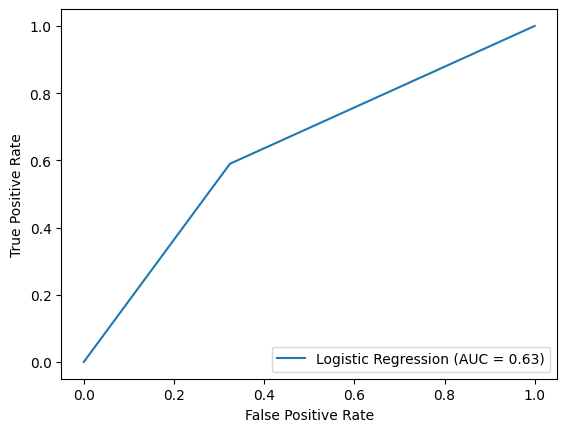

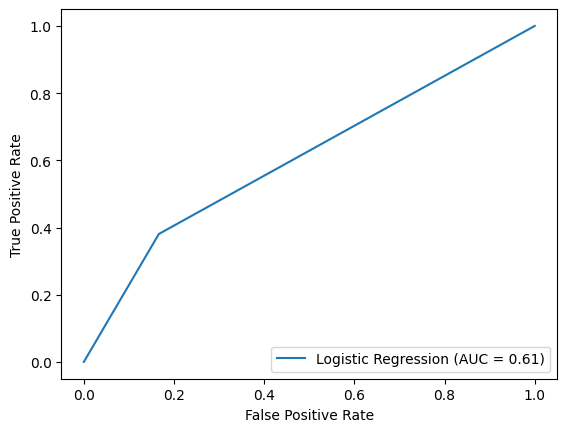

In [543]:
# Calculate evaluation metrics and scores for the validation and training sets
conf_matrix_validation, class_report_validation, auc_validation, acc_validation = get_scores(y_pred_validation, Y_validation)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train_resampled)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the validation set
print('======== Validation Set ==========')
print_scores(conf_matrix_validation, class_report_validation, auc_validation, acc_validation)

# Plot the ROC curve for the training set
fpr_lt, tpr_lt, thresholds_lt = roc_curve(y_pred_train, Y_train_resampled)
roc_auc_lt = auc(fpr_lt, tpr_lt)
display = RocCurveDisplay(fpr=fpr_lt, tpr=tpr_lt, roc_auc=roc_auc_lt, estimator_name='Logistic Regression')
display.plot()

# Plot the ROC curve for the validation set
fpr_lv, tpr_lv, thresholds_lv = roc_curve(y_pred_validation, Y_validation)
roc_auc_lv = auc(fpr_lv, tpr_lv)
display = RocCurveDisplay(fpr=fpr_lv, tpr=tpr_lv, roc_auc=roc_auc_lv, estimator_name='Logistic Regression')
display.plot()

In [544]:
# Setting hyperparameters for Logistic Regression for the Grid Search.
param_dist = {
    'penalty' : ['l2'],
    'C' : [0.5, 1.0, 1.5],
    'solver' : ['liblinear'],
}

# Initializing stratified K-fold cross-validation.
skf = StratifiedKFold(n_splits=5)

In [545]:
# Setting up GridSearchCV to search through the parameter space.
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Running the GridSearchCV on the training data.
random_search.fit(X_train_resampled, Y_train_resampled)

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(random_search.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.07858,0.00315,0.013205,0.000634,1.5,l2,liblinear,"{'C': 1.5, 'penalty': 'l2', 'solver': 'libline...",0.632388,0.639086,0.637367,0.626724,0.650769,0.637267,0.008007,1


In [546]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_resampled, Y_train_resampled)

# Predicting on the training dataset and computing the accuracy
Y_pred_train_tuned = model.predict(X_train_resampled)
print(accuracy_score(Y_train_resampled, Y_pred_train_tuned))

# Predicting on the test dataset and computing the accuracy
Y_pred_validation_tuned = model.predict(X_validation)
print(accuracy_score(Y_validation, Y_pred_validation_tuned))

0.6375029557815086
0.6561206781471098


======== Training Set ==========
AUC :  0.6335150813408326
Accuracy :  0.6375029557815086
Confusion Matrix:
[[4689 2240]
 [2359 3399]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      6929
           1       0.60      0.59      0.60      5758

    accuracy                           0.64     12687
   macro avg       0.63      0.63      0.63     12687
weighted avg       0.64      0.64      0.64     12687

======== Validation Set ==========
AUC :  0.6075313838482665
Accuracy :  0.6561206781471098
Confusion Matrix:
[[3794  755]
 [1821 1121]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      4549
           1       0.60      0.38      0.47      2942

    accuracy                           0.66      7491
   macro avg       0.64      0.61      0.61      7491
weighted avg       0.65      0.66      0.64      7491



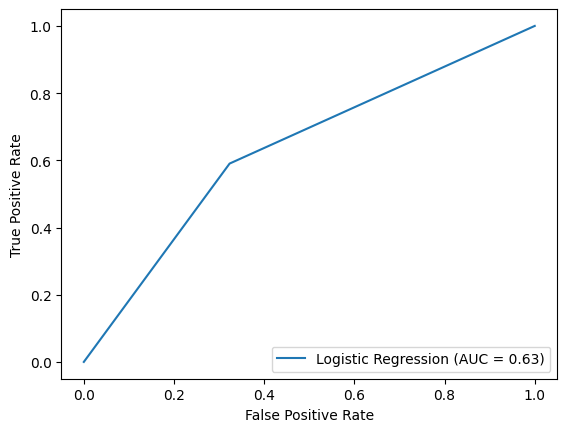

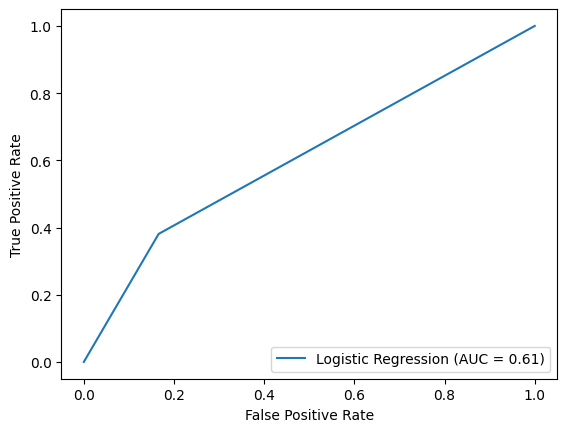

In [547]:
# Calculate evaluation metrics and scores for the validation and training sets after Hyperparameter Tuning
conf_matrix_validation, class_report_validation, auc_validation, acc_validation = get_scores(Y_pred_validation_tuned, Y_validation)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(Y_pred_train_tuned, Y_train_resampled)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the validation set
print('======== Validation Set ==========')
print_scores(conf_matrix_validation, class_report_validation, auc_validation, acc_validation)

# Plot the ROC curve for the training set
fpr_lt, tpr_lt, thresholds_lt = roc_curve(Y_pred_train_tuned, Y_train_resampled)
roc_auc_lt = auc(fpr_lt, tpr_lt)
display = RocCurveDisplay(fpr=fpr_lt, tpr=tpr_lt, roc_auc=roc_auc_lt, estimator_name='Logistic Regression')
display.plot()

# Plot the ROC curve for the validation set
fpr_lv, tpr_lv, thresholds_lv = roc_curve(Y_pred_validation_tuned, Y_validation)
roc_auc_lv = auc(fpr_lv, tpr_lv)
display = RocCurveDisplay(fpr=fpr_lv, tpr=tpr_lv, roc_auc=roc_auc_lv, estimator_name='Logistic Regression')
display.plot()

**Naïve Bayes Classifier**

In [548]:
from sklearn.naive_bayes import CategoricalNB

In [549]:
cnb = CategoricalNB()

In [550]:
X_train_resampled

,THHLD_NUMPER,age,is_employed,is_vaccinated,is_straight,is_white,cov_highly_symptomatic,region,is_female
11055,0.000000,0.657143,1,1,1,1,0,0.256879,1
59769,0.111111,0.485714,1,1,1,1,0,0.244930,1
8288,0.333333,0.314286,1,0,1,1,1,0.256879,1
64132,0.333333,0.314286,1,1,1,1,0,0.256879,1
2642,0.111111,0.571429,1,1,1,1,1,0.256879,1
...,...,...,...,...,...,...,...,...,...
1808,0.333333,0.471429,1,0,1,1,0,0.244930,1
64472,0.111111,0.100000,1,1,0,1,0,0.244930,1
64789,0.000000,0.171429,1,1,0,1,1,0.267067,1
45026,0.111111,0.514286,0,1,1,0,1,0.256879,1


In [551]:
# Training the Categorical Naive Bayes model on Categorical Columns
X_train_categorical = X_train_resampled[['is_employed',	'is_vaccinated',	'is_straight',	'is_white',	'cov_highly_symptomatic',	'region',	'is_female']]
cnb = cnb.fit(X_train_categorical, Y_train_resampled)

AUC :  0.6299176507897912
Accuracy :  0.6360841806573658
Confusion Matrix:
[[4831 2217]
 [2400 3239]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      7048
           1       0.59      0.57      0.58      5639

    accuracy                           0.64     12687
   macro avg       0.63      0.63      0.63     12687
weighted avg       0.64      0.64      0.64     12687



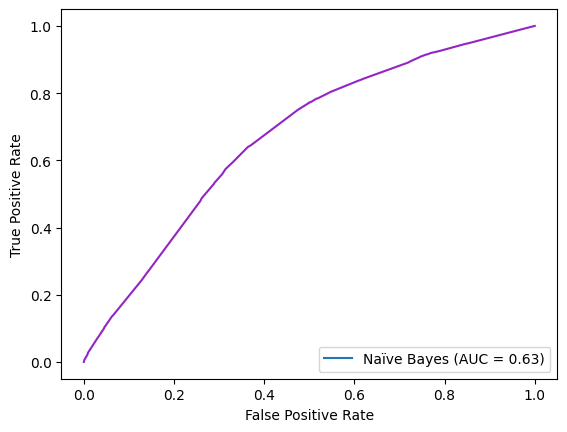

In [552]:
# Making predictions on the training data. y_hat_prob contains the predicted probabilities for each class,
# while y_hat contains the predicted class labels.
y_hat_prob = cnb.predict_proba(X_train_categorical)
y_hat = cnb.predict(X_train_categorical)

# Evaluating the model's performance on the training data using previously defined scoring functions.
conf_matrix_nbt, class_report_nbt, auc_nbt, acc_nbt = get_scores(Y_train_resampled, y_hat)
print_scores(conf_matrix_nbt, class_report_nbt, auc_nbt, acc_nbt)

# Plotting the ROC curve for the model using the true labels and the predicted probabilities for class 1.
fpr_nbt, tpr_nbt, thresholds_nbt = roc_curve(Y_train_resampled, y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr_nbt, tpr=tpr_nbt, roc_auc=auc_nbt, estimator_name='Naïve Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

In [553]:
X_validation_categorical= X_validation[['is_employed',	'is_vaccinated',	'is_straight',	'is_white',	'cov_highly_symptomatic',	'region',	'is_female']]

AUC :  0.6352232920121439
Accuracy :  0.6665331731411026
Confusion Matrix:
[[3919 1696]
 [ 802 1074]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      5615
           1       0.39      0.57      0.46      1876

    accuracy                           0.67      7491
   macro avg       0.61      0.64      0.61      7491
weighted avg       0.72      0.67      0.68      7491



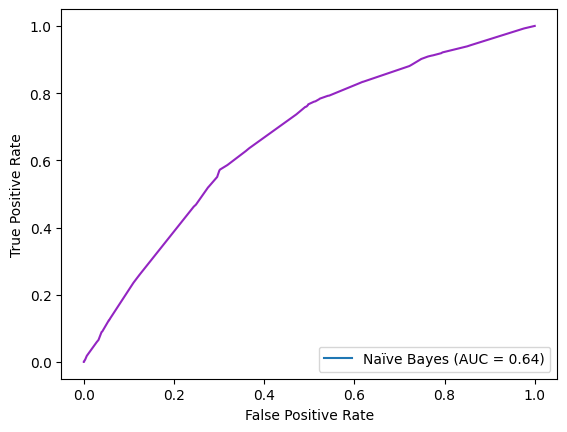

In [554]:
# Making predictions on the validation data. y_hat_prob contains the predicted probabilities for each class,
# while y_hat contains the predicted class labels.
y_hat_prob = cnb.predict_proba(X_validation_categorical)
y_hat = cnb.predict(X_validation_categorical)

# Evaluating the model's performance on the training data using previously defined scoring functions.
conf_matrix_nbv, class_report_nbv, auc_nbv, acc_nbv = get_scores(Y_validation, y_hat)
print_scores(conf_matrix_nbv, class_report_nbv, auc_nbv, acc_nbv)

# Plotting the ROC curve for the model using the true labels and the predicted probabilities for class 1.
fpr_nbv, tpr_nbv, thresholds_nbv = roc_curve(Y_validation, y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr_nbv, tpr=tpr_nbv, roc_auc=auc_nbv, estimator_name='Naïve Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

In [555]:
# Setting hyperparameters for Naïve Bayes Classifier for the Grid Search.
param_dist = {
    'alpha' : [20, 40, 60, 80, 100]
}

# Initializing stratified K-fold cross-validation.
skf = StratifiedKFold(n_splits=5)

In [556]:
# Setting up GridSearchCV to search through the parameter space.
random_search = GridSearchCV(
    cnb, param_grid=param_dist, cv=skf
)

# Running the GridSearchCV on the training data.
random_search.fit(X_train_categorical, Y_train_resampled)

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(random_search.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009768,0.001748,0.003349,0.000231,20,{'alpha': 20},0.6316,0.633964,0.634214,0.630666,0.64998,0.636085,0.007079,1
1,0.009394,0.000463,0.003491,0.000106,40,{'alpha': 40},0.6316,0.633964,0.634214,0.630666,0.64998,0.636085,0.007079,1
2,0.009530,0.000815,0.003291,0.000046,60,{'alpha': 60},0.6316,0.633964,0.634214,0.630666,0.64998,0.636085,0.007079,1
3,0.009946,0.002277,0.003881,0.000529,80,{'alpha': 80},0.6316,0.633964,0.634214,0.630666,0.64998,0.636085,0.007079,1
4,0.009373,0.000826,0.003450,0.000098,100,{'alpha': 100},0.6316,0.633964,0.634214,0.630666,0.64998,0.636085,0.007079,1


In [557]:
print(random_search.best_params_)

{'alpha': 20}


In [558]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = cnb.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_resampled, Y_train_resampled)

# Predicting on the training dataset and computing the accuracy
Y_pred_train_tuned = model.predict(X_train_resampled)
print(accuracy_score(Y_train_resampled, Y_pred_train_tuned))

# Predicting on the test dataset and computing the accuracy
Y_pred_validation_tuned = model.predict(X_validation)
print(accuracy_score(Y_validation, Y_pred_validation_tuned))

0.6357688972964451
0.6663996796155387


======== Training Set ==========
AUC :  0.6305925632320546
Accuracy :  0.6357688972964451
Confusion Matrix:
[[4823 2396]
 [2225 3243]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      7219
           1       0.58      0.59      0.58      5468

    accuracy                           0.64     12687
   macro avg       0.63      0.63      0.63     12687
weighted avg       0.64      0.64      0.64     12687

======== Validation Set ==========
AUC :  0.6090562318043234
Accuracy :  0.6663996796155387
Confusion Matrix:
[[3916  800]
 [1699 1076]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      4716
           1       0.57      0.39      0.46      2775

    accuracy                           0.67      7491
   macro avg       0.64      0.61      0.61      7491
weighted avg       0.65      0.67      0.65      7491



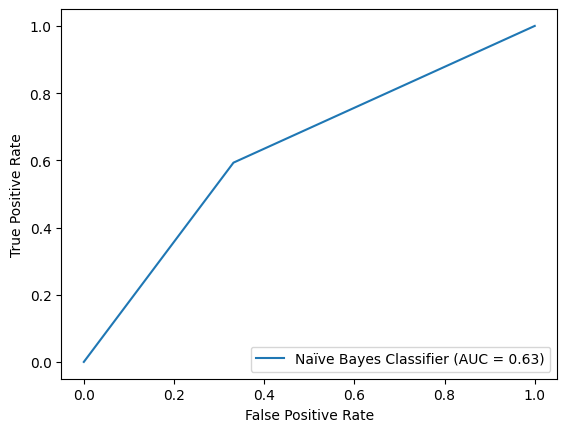

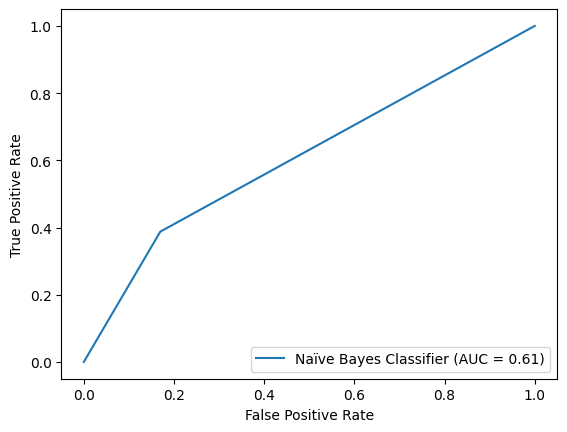

In [559]:
# Calculate evaluation metrics and scores for the validation and training sets after Hyperparameter Tuning
conf_matrix_validation, class_report_validation, auc_validation, acc_validation = get_scores(Y_pred_validation_tuned, Y_validation)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(Y_pred_train_tuned, Y_train_resampled)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the validation set
print('======== Validation Set ==========')
print_scores(conf_matrix_validation, class_report_validation, auc_validation, acc_validation)

# Plot the ROC curve for the training set
fpr_nbc, tpr_nbc, thresholds_nbc = roc_curve(Y_pred_train_tuned, Y_train_resampled)
roc_auc_nbc = auc(fpr_nbc, tpr_nbc)
display = RocCurveDisplay(fpr=fpr_nbc, tpr=tpr_nbc, roc_auc=roc_auc_nbc, estimator_name='Naïve Bayes Classifier')
display.plot()

# Plot the ROC curve for the validation set
fpr_nbcv, tpr_nbcv, thresholds_nbcv = roc_curve(Y_pred_validation_tuned, Y_validation)
roc_auc_nbcv = auc(fpr_nbcv, tpr_nbcv)
display = RocCurveDisplay(fpr=fpr_nbcv, tpr=tpr_nbcv, roc_auc=roc_auc_nbcv, estimator_name='Naïve Bayes Classifier')
display.plot()

**Random Forest Classifier**

In [560]:
model = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', oob_score=True)

In [561]:
model = model.fit(X_train_resampled, Y_train_resampled)

In [562]:
# Predicting the target variable on the training set and evaluating the model's accuracy.
Y_pred = model.predict(X_train_resampled)
accuracy_score(Y_train_resampled, Y_pred)

0.8660045716087333

In [563]:
# Predicting the target variable on the validation set and evaluating the model's accuracy. Shows a significant drop.
Y_pred = model.predict(X_validation)
accuracy_score(Y_validation, Y_pred)

0.5937792017087171

In [564]:
# Setting hyperparameters for Random Forest for the Grid Search.
param_dist = {
    'n_estimators' : [50, 100, 150, 200],
    'max_depth' : [5, 10, 15],
    'min_samples_leaf' : [5, 10, 15, 20 ,25],
    'max_features' : ['sqrt']
}

# Initializing stratified K-fold cross-validation. This ensures each fold has the same proportion of target labels as the whole dataset.
skf = StratifiedKFold(n_splits=5)

In [565]:
# Setting up GridSearchCV to search through the parameter space.
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Running the GridSearchCV on the training data.
random_search.fit(X_train_resampled, Y_train_resampled)

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(random_search.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,0.969452,0.009785,0.04704,0.001121,15,sqrt,10,100,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",0.628448,0.637904,0.633425,0.60741,0.649586,0.631355,0.013866,1


In [566]:
print(random_search.best_params_)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}


In [438]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_resampled, Y_train_resampled)

# Predicting on the training dataset and computing the accuracy
Y_pred_train = model.predict(X_train_resampled)
print(accuracy_score(Y_train_resampled, Y_pred_train))

# Predicting on the test dataset and computing the accuracy
Y_pred_validation = model.predict(X_validation)
print(accuracy_score(Y_validation, Y_pred_validation))

0.664302041459762
0.617808036310239


======== Training Set ==========
AUC :  0.6672854449801736
Accuracy :  0.664302041459762
Confusion Matrix:
[[4417 1628]
 [2631 4011]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.73      0.67      6045
           1       0.71      0.60      0.65      6642

    accuracy                           0.66     12687
   macro avg       0.67      0.67      0.66     12687
weighted avg       0.67      0.66      0.66     12687

======== Validation Set ==========
AUC :  0.5991734058592791
Accuracy :  0.617808036310239
Confusion Matrix:
[[3393  641]
 [2222 1235]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.84      0.70      4034
           1       0.66      0.36      0.46      3457

    accuracy                           0.62      7491
   macro avg       0.63      0.60      0.58      7491
weighted avg       0.63      0.62      0.59      7491



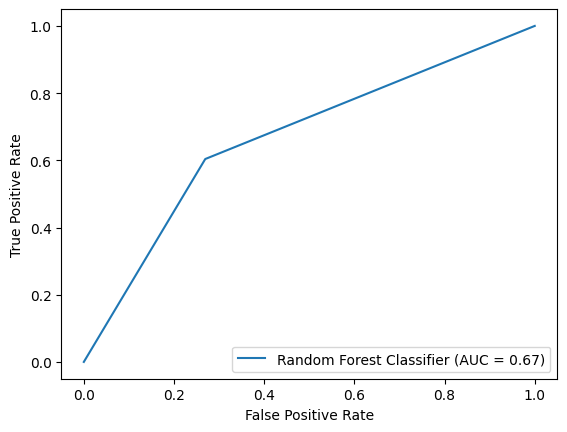

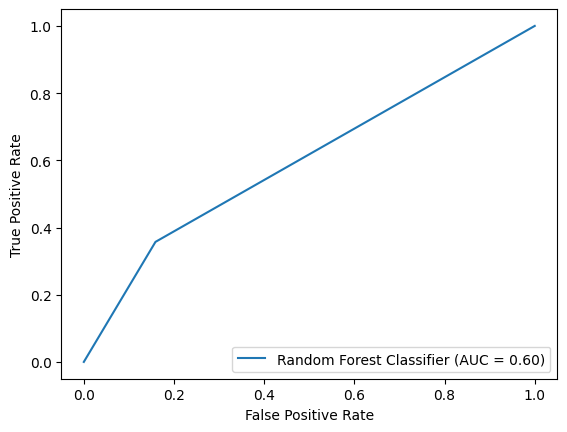

In [567]:
# Calculate evaluation metrics and scores for the validation and training sets
conf_matrix_validation, class_report_validation, auc_validation, acc_validation = get_scores(Y_pred_validation, Y_validation)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(Y_pred_train, Y_train_resampled)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the validation set
print('======== Validation Set ==========')
print_scores(conf_matrix_validation, class_report_validation, auc_validation, acc_validation)

# Plot the ROC curve for the training set
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_pred_train, Y_train_resampled)
roc_auc_rf = auc(fpr_rf, tpr_rf)
display = RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=roc_auc_rf, estimator_name='Random Forest Classifier')
display.plot()

# Plot the ROC curve for the validation set
fpr_rfv, tpr_rfv, thresholds_rfv = roc_curve(Y_pred_validation, Y_validation)
roc_auc_rfv = auc(fpr_rfv, tpr_rfv)
display = RocCurveDisplay(fpr=fpr_rfv, tpr=tpr_rfv, roc_auc=roc_auc_rfv, estimator_name='Random Forest Classifier')
display.plot()

**'Best' Model Prediction on the Training Set**

Based on weighted f1 score and AUC score, the Naïve Bayes Classifier performed the best, so I use it to make predictions on the test set to assess generalizability (note that I only used categorical features).

In [568]:
X_test_categorical= X_test[['is_employed',	'is_vaccinated',	'is_straight',	'is_white',	'cov_highly_symptomatic',	'region',	'is_female']]

In [569]:
#Note that alpha=20 was the best parameter value found on GridSearchCV
cnb = CategoricalNB(alpha=20)

In [574]:
# Train the model on the training dataset
model = cnb.fit(X_train_categorical, Y_train_resampled)

AUC :  0.6380824311942173
Accuracy :  0.6672006407689227
Confusion Matrix:
[[3900 1695]
 [ 798 1098]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      5595
           1       0.39      0.58      0.47      1896

    accuracy                           0.67      7491
   macro avg       0.61      0.64      0.61      7491
weighted avg       0.72      0.67      0.68      7491



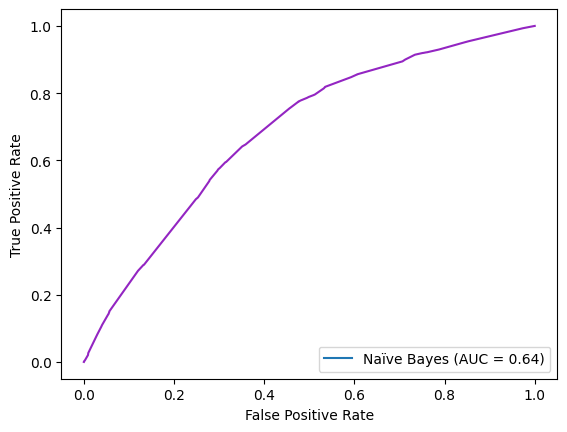

In [576]:
# Making predictions on the test data. y_hat_prob contains the predicted probabilities for each class,
# while y_hat contains the predicted class labels.
y_hat_prob = cnb.predict_proba(X_test_categorical)
y_hat = cnb.predict(X_test_categorical)

# Evaluating the model's performance on the test data using previously defined scoring functions.
conf_matrix_nbtt, class_report_nbtt, auc_nbtt, acc_nbtt = get_scores(Y_test, y_hat)
print_scores(conf_matrix_nbtt, class_report_nbtt, auc_nbtt, acc_nbtt)

# Plotting the ROC curve for the model using the true labels and the predicted probabilities for class 1.
fpr_nbtt, tpr_nbtt, thresholds_nbtt = roc_curve(Y_test, y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr_nbtt, tpr=tpr_nbtt, roc_auc=auc_nbtt, estimator_name='Naïve Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')